In [7]:
# Algorithmic Trading Model for Microsoft Stock using Deep Learning
# Combines historical stock data with sentiment analysis from news headlines
# Utilizes Transformer model with attention mechanisms

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import matplotlib.pyplot as plt

# Download NLTK data files
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Step 1: Load Historical Stock Data for Microsoft (MSFT)
msft = yf.download('MSFT', start='2010-01-01', end=datetime.date.today())
msft.reset_index(inplace=True)

# Features from historical data
msft['Day'] = msft['Date'].dt.day
msft['Month'] = msft['Date'].dt.month
msft['Year'] = msft['Date'].dt.year
msft['DayOfWeek'] = msft['Date'].dt.dayofweek



[*********************100%***********************]  1 of 1 completed


In [9]:
# Step 2: Load and Process Financial News Headlines
# For the purpose of this example, we'll simulate news headlines
# In practice, you should fetch real financial news data

# Simulated news headlines (Replace this with actual news data fetching)
news_data = pd.DataFrame({
    'Date': pd.date_range(start='2010-01-01', periods=len(msft), freq='D'),
    'Headline': np.random.choice([
        'Microsoft launches new product today',
        'Stock market falls due to economic concerns',
        'Tech stocks soar amidst new advancements',
        'Global markets unstable amid political tensions',
        'Positive earnings report boosts investor confidence'
    ], size=len(msft))
})

# Merge stock data with news headlines
data = pd.merge(msft, news_data, on='Date', how='left')



In [10]:
# Step 3: Sentiment Analysis on News Headlines
sid = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Headline'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

# Fill missing sentiment values with zero if no headline is available
data['Sentiment'].fillna(0, inplace=True)

<ipython-input-10-33b238d74543>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Sentiment'].fillna(0, inplace=True)


In [11]:
# Step 4: Prepare Data for the Model
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Day', 'Month', 'Year', 'DayOfWeek']
target = 'Adj Close'

# Scale features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Define input and output sequences
sequence_length = 60  # Use the past 60 days to predict the next day's price

def create_sequences(data, seq_length, features, target):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[features].values[i-seq_length:i])
        y.append(data[target].values[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = create_sequences(data, sequence_length, features, target)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [12]:
# Step 5: Build the Transformer Model
def build_transformer_model(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))

    # Transformer encoder layer
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=feature_dim, dropout=0.1)(x, x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_transformer_model(sequence_length, len(features))
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 10)         │             20 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 10)         │          1,730 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 10)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 10)         │             20 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 60, 128)        │          1,408 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 60, 128)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ dropout_2[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            129 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,307 (12.92 KB)

 Trainable params: 3,307 (12.92 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Step 6: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 5299.3047 - val_loss: 53387.9297
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3317.9377 - val_loss: 38198.1523
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1440.1102 - val_loss: 21988.8809
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 321.2549 - val_loss: 12314.0605
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 110.9675 - val_loss: 8312.1572
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 61.3783 - val_loss: 6238.1025
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 49.9679 - val_loss: 5047.0977
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 35.0221 - val_loss: 4397.8774
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 32.0669 - val_loss: 3858.5881
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 29.3066 - val_loss: 3375.5747
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 25.9639 - val_loss: 3133.0559
Epoch 1

In [14]:
# Step 7: Evaluate the Model
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((predictions.shape[0], len(features)-1)), predictions))
)[:, -1]
y_test_inverse = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], len(features)-1)), y_test.reshape(-1,1)))
)[:, -1]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions_inverse - y_test_inverse) ** 2))
print(f'Root Mean Squared Error: {rmse:.2f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Root Mean Squared Error: 599.23


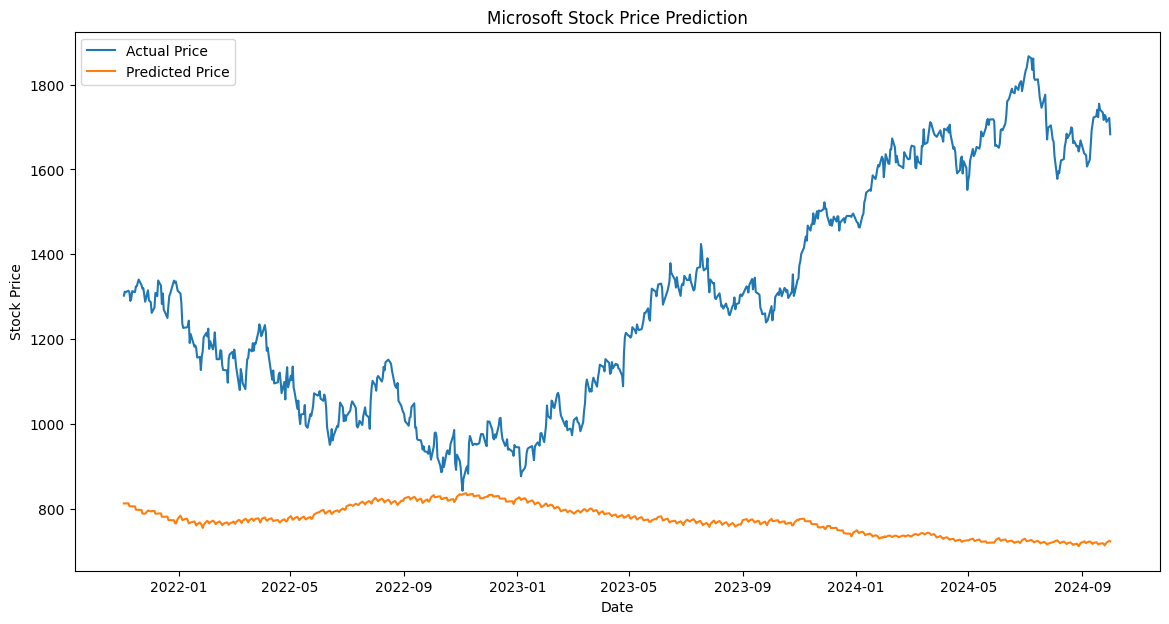

In [22]:
# Step 8: Visualize the Results
plt.figure(figsize=(14,7))
plt.plot(data['Date'][-len(y_test):], y_test_inverse, label='Actual Price')
plt.plot(data['Date'][-len(y_test):], predictions_inverse, label='Predicted Price')
plt.plot(data['Date'][-len(y_test):], predictions_inverse, label='Predicted Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [16]:
# Step 9: Generate Trading Signals
# If the predicted price is higher than today's price, buy signal; else, sell signal
trading_signals = ['Buy' if predictions_inverse[i] > y_test_inverse[i-1] else 'Sell' for i in range(1, len(predictions_inverse))]
trading_dates = data['Date'][-len(y_test):].iloc[1:]

trading_strategy = pd.DataFrame({
    'Date': trading_dates,
    'Signal': trading_signals
})

print(trading_strategy.head())

           Date Signal
2981 2021-11-04   Sell
2982 2021-11-05   Sell
2983 2021-11-08   Sell
2984 2021-11-09   Sell
2985 2021-11-10   Sell


In [19]:
# Step 10: Backtesting the Strategy (Simplified)
initial_money = 10000
shares = 5
money = initial_money

for i in range(len(trading_signals)):
    price = y_test_inverse[i+1]  # +1 because we started from i=1
    if trading_signals[i] == 'Buy' and money > price:
        shares_to_buy = money // price
        shares += shares_to_buy
        money -= shares_to_buy * price
    elif trading_signals[i] == 'Sell' and shares > 0:
        money += shares * price
        shares = 0



In [20]:
# Final portfolio value
final_value = money + shares * y_test_inverse[-1]
print(f'Initial Money: ${initial_money}')
print(f'Final Portfolio Value: ${final_value:.2f}')


Initial Money: $10000
Final Portfolio Value: $16559.83
